In [99]:
import csv 
import pandas as pd
import io
# the load_vectors function read pre-trained word embedding
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = [float(i) for i in tokens[1:]]
    return data


In [100]:
import numpy as np
vecs = load_vectors('wiki-news-300d-1M.vec')
# we manually add a zero vector '<pad>' and a random 300-D vector '<unk>' for unseen vectors
vecs['<pad>'] = list(np.zeros((300)))
vecs['<unk>'] = list(np.random.normal(scale=0.4, size=(300, )))

In [101]:
# read train data
train = pd.read_csv('snli_train.tsv', delimiter='\t')
premise = []
hyp = []
target = []
for i in range(len(train)):
    premise.append(train.iloc[i]['sentence1'].split())
    hyp.append(train.iloc[i]['sentence2'].split())
    target.append(train.iloc[i]['label'])
# change labels to numerics    
label_dcit = {'entailment': 0,  'neutral': 1, 'contradiction': 2}
labels = []
for label in target:
    labels.append(label_dcit[label])

In [102]:
# read validation data
valid = pd.read_csv('snli_val.tsv', delimiter='\t')
premise_val = []
hyp_val = []
target_val = []
for i in range(len(valid)):
    premise_val.append(valid.iloc[i]['sentence1'].split())
    hyp_val.append(valid.iloc[i]['sentence2'].split())
    target_val.append(valid.iloc[i]['label'])
    
label_dcit = {'entailment': 0,  'neutral': 1, 'contradiction': 2}
labels_val = []
for label in target_val:
    labels_val.append(label_dcit[label])

In [103]:
# build vocab and get char2id and id2char as we did before
PAD_IDX = 0
UNK_IDX = 1
def build_vocab(sentences):
    # create vocab of words
    max_sent_len = max([len(sent[0]) for sent in sentences])
    word_dict = {}
    for sent in sentences:
        for word in sent:
            if word not in word_dict:
                word_dict[word] = ''
    word_set = list(set(word_dict))
    id2char = word_set
    char2id = dict(zip(word_set, range(2,2+len(word_set))))
    id2char = ['<pad>', '<unk>'] + id2char
    char2id['<pad>'] = PAD_IDX
    char2id['<unk>'] = UNK_IDX
    return char2id, id2char, max_sent_len

In [104]:
char2id, id2char, max_sent_len = build_vocab(sentences = premise + hyp)

In [105]:
# prepare data loader for PyTorch 
from torch.utils.data import Dataset
class VocabDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    # we feed two sentences into one single loader
    def __init__(self, s1, s2, label, char2id):

        self.s1, self.s2, self.target_list = s1, s2, label
        assert (len(self.s1) == len(self.target_list) == len(self.s2))
        self.char2id = char2id


    def __len__(self):
        return len(self.s1)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        s1_idx = [self.char2id[c] if c in self.char2id.keys() else UNK_IDX  for c in self.s1[key][:max_sent_len]]
        s2_idx = [self.char2id[c] if c in self.char2id.keys() else UNK_IDX  for c in self.s2[key][:max_sent_len]]
        label = self.target_list[key]
        return [s1_idx, len(s1_idx),s2_idx, len(s2_idx), label]

In [106]:
def collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    label_list = []
    s1 = []
    s1_len = []
    s2 = []
    s2_len = []

    for datum in batch:
        # get label data
        label_list.append(datum[4])
        # get data for the 1st sentence 
        s1_len.append(datum[1])
        # get data for the 2nd sentence 
        s2_len.append(datum[3])
        
    # padding
    for datum in batch:
        padded_vec_s1 = np.pad(np.array(datum[0]),
                                pad_width=((0,max_sent_len-datum[1])),
                                mode="constant", constant_values=0)
        padded_vec_s2 = np.pad(np.array(datum[2]),
                                pad_width=((0,max_sent_len-datum[3])),
                                mode="constant", constant_values=0)
        s1.append(padded_vec_s1)
        s2.append(padded_vec_s2)
    
    # sort sentences in descending length as per RNN's input requirement
    ind_s1 = np.argsort(s1_len)[::-1]
    ind_s2 = np.argsort(s2_len)[::-1]
    s1 = np.array(s1)[ind_s1]
    s1_len = np.array(s1_len)[ind_s1]
    s2 = np.array(s2)[ind_s2]
    s2_len = np.array(s2_len)[ind_s2]
    # we do NOT sort the labels, we don't have to unsort it later on
    label_list = np.array(label_list)
    # return sorted sentences along with the idx we used to sort them so that we could unsort them later according to this idx
    return [torch.from_numpy(np.array(s1)), torch.LongTensor(s1_len), ind_s1, torch.from_numpy(np.array(s2)), torch.LongTensor(s2_len), ind_s2, torch.LongTensor(label_list)]


In [107]:
train_set =VocabDataset(premise, hyp, labels, char2id)
val_set =VocabDataset(premise_val, hyp_val, labels_val, char2id)

In [108]:
import torch
import torch.nn as nn
import torch.nn.functional as F
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=collate_func,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_set,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=collate_func,
                                           shuffle=True)

In [109]:
# this function takes a permutation, and returns its inverse
def inverse(perm):
    inverse = [1] * len(perm)
    # permute things back
    for index, perm in enumerate(perm):
        inverse[perm] = index
    return inverse

In [110]:
# this function prepare the embedding layer 
def prep_emb_layer(batch_data, cold_w2v, emb_size = 300):
    """
    batch_data: input data to be embedded
    cold_w2v: pre-trained word2vec 
    emb_size: this size should match length of vectors in cold_w2v
    """
    # since batch first, len(batch_data) is our first dimension
    embed = np.zeros((len(batch_data),max_sent_len, emb_size))
    for i in range(len(batch_data)):
        for j in range(len(batch_data[i])):
            try:
                embed[i,j,:] = np.array(cold_w2v[id2char[batch_data[i][j]]])
            # for unseen words, we map it to '<unk>'
            except KeyError:
                embed[i,j,:] = np.array(cold_w2v['<unk>'])
    return torch.from_numpy(embed).float()

In [111]:
# BiGRU is our encoder
class BiGRU(nn.Module):
    def __init__(self, hidden_size, num_layers, num_classes, emb_size=300):
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        super(BiGRU, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.gru = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

    def forward(self, data, lengths, sort_idx):
        # we will need sort_idx to unsort our data
        
        # get embedding of characters
        embed = prep_emb_layer(data, vecs)
        # send data to GPU
        embed = embed.to(device)
        # pack padded sequence
        sent_packed = torch.nn.utils.rnn.pack_padded_sequence(embed, lengths.numpy(), batch_first=True)
        # use hidden state as our output
        _, hn = self.gru(sent_packed)
        cat = torch.cat((hn[0], hn[1]), 1)
        # unsort the output so that correspondences are preserved 
        reverse_idx = inverse(sort_idx)
        un_sort = cat.index_select(0, torch.LongTensor(reverse_idx).to(device))

        return un_sort

# Fc_GRU consists of encoder and fully connected layers
class Fc_GRU(nn.Module):
    def __init__(self, hidden_size, num_layers, num_classes, Fc_dim, dropout=False, interact=False):
        super(Fc_GRU, self).__init__()

        self.encoder = BiGRU(hidden_size, num_layers, num_classes, emb_size =300)
        self.interact = interact
        inputdim = 4*hidden_size
        # when interacting, we have more input for fully connected layers
        if interact:
            inputdim = 6*hidden_size
        # add dropout layers when needed
        if not dropout:
            self.fc = nn.Sequential(
                    nn.Linear(inputdim, Fc_dim),
                    nn.ReLU(),
                    nn.Linear(Fc_dim, Fc_dim),
                    nn.ReLU(),
                    nn.Linear(Fc_dim, num_classes)
                    )
        else:
            self.fc = nn.Sequential(
                    nn.Dropout(),
                    nn.Linear(inputdim, Fc_dim),
                    nn.ReLU(),
                    nn.Dropout(),
                    nn.Linear(Fc_dim, Fc_dim),
                    nn.ReLU(),
                    nn.Dropout(),
                    nn.Linear(Fc_dim, num_classes)
                    )
    def forward(self, s1, l1, idx1, s2, l2, idx2):
        s1 = self.encoder(s1, l1, idx1)
        s2 = self.encoder(s2, l2, idx2)
        
        # for interactions, we think it might be more informative to keep original, encoded sentences as well
        if not self.interact:
            cat = torch.cat((s1, s2), 1)
        else:
        # we are considering (s1, s1*s2, s2) instead of s1*s2 alone
            cat = torch.cat((s1, s1*s2, s2), 1)
        logits = self.fc(cat)
        return logits

In [112]:
import torch.nn.functional as F
def test_GRU_model(data, model):
    """
    Help function that tests GRU model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    total_loss = 0 
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    for (data_1, lengths_1, idx_1,data_2, lengths_2, idx_2, label) in data:
        # send data to GPU 
        data_1,data_2, label = \
            data_1.to(device),data_2.to(device), label.to(device)
        outputs = F.softmax(model(data_1, lengths_1, idx_1, data_2, lengths_2, idx_2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        # keep track of total loss
        total_loss += criterion(outputs, label).item()
        total += label.size(0)
        correct += predicted.eq(label.view_as(predicted)).sum().item()
    return (100 * correct / total), total_loss

In [113]:
def count_parameters(model):
    """
    Help function that counts the number of trainable parameters in a model
    Credit: https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/9
    """
    return sum(par.numel() for par in model.parameters() if par.requires_grad)

In [114]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
train_acc_hidden_size = {}
train_loss_hidden_size = {}
val_acc_hidden_size = {}
val_loss_hidden_size = {}
num_pars = {}
# tune hidden size for GRU model 
for hid_size in [100, 200, 800, 1600]:
    epoch_acc_train = []
    epoch_loss_train = []
    epoch_acc_val = []
    epoch_loss_val = []
    model = Fc_GRU(hidden_size=hid_size, num_layers=1, num_classes=3, Fc_dim = 300, dropout=False)
    num_pars[hid_size] = count_parameters(model)
    
    model = model.to(device)
    learning_rate = 3e-4
    num_epochs = 15
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        for i,(data_1, lengths_1, idx_1,data_2, lengths_2, idx_2, label) in enumerate(train_loader):
            data_1,data_2, label = data_1.to(device),data_2.to(device), label.to(device)
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data_1, lengths_1, idx_1, data_2, lengths_2, idx_2)
            loss = criterion(outputs, label)

            # Backward and optimize
            loss.backward()
            optimizer.step()
        val_acc, val_loss = test_GRU_model(val_loader , model)
        train_acc, train_loss =test_GRU_model(train_loader , model)
        epoch_acc_val.append(val_acc)
        epoch_acc_train.append(train_acc)
        epoch_loss_val.append(val_loss)
        epoch_loss_train.append(train_loss)
        print("Epoch {} done!".format(epoch))
    train_loss_hidden_size[hid_size] = epoch_loss_train
    val_loss_hidden_size[hid_size] = epoch_loss_val
    train_acc_hidden_size[hid_size] = epoch_acc_train
    val_acc_hidden_size[hid_size] = epoch_acc_val

Epoch 0 done!
Epoch 1 done!
Epoch 2 done!
Epoch 3 done!
Epoch 4 done!
Epoch 5 done!
Epoch 6 done!
Epoch 7 done!
Epoch 8 done!
Epoch 9 done!
Epoch 10 done!
Epoch 11 done!
Epoch 12 done!
Epoch 13 done!
Epoch 14 done!
Epoch 0 done!
Epoch 1 done!
Epoch 2 done!
Epoch 3 done!
Epoch 4 done!
Epoch 5 done!
Epoch 6 done!
Epoch 7 done!
Epoch 8 done!
Epoch 9 done!
Epoch 10 done!
Epoch 11 done!
Epoch 12 done!
Epoch 13 done!
Epoch 14 done!
Epoch 0 done!
Epoch 1 done!
Epoch 2 done!
Epoch 3 done!
Epoch 4 done!
Epoch 5 done!
Epoch 6 done!
Epoch 7 done!
Epoch 8 done!
Epoch 9 done!
Epoch 10 done!
Epoch 11 done!
Epoch 12 done!
Epoch 13 done!
Epoch 14 done!
Epoch 0 done!
Epoch 1 done!
Epoch 2 done!
Epoch 3 done!
Epoch 4 done!
Epoch 5 done!
Epoch 6 done!
Epoch 7 done!
Epoch 8 done!
Epoch 9 done!
Epoch 10 done!
Epoch 11 done!
Epoch 12 done!
Epoch 13 done!
Epoch 14 done!


In [18]:
import pickle
pickle.dump( train_acc_hidden_size, open( "train_acc_GRU_hdn.p", "wb" ) )
pickle.dump( val_acc_hidden_size, open( "val_acc_GRU_hdn.p", "wb" ) )
pickle.dump( train_loss_hidden_size, open( "train_loss_GRU_hdn.p", "wb" ) )
pickle.dump( val_loss_hidden_size, open( "val_loss_GRU_hdn.p", "wb" ) )
pickle.dump( num_pars, open( "num_pars_GRU_hdn.p", "wb" ) )

In [4]:
import pickle
train_acc_hidden_size = pickle.load( open( "train_acc_GRU_hdn.p", "rb" ) )
val_acc_hidden_size = pickle.load( open( "val_acc_GRU_hdn.p", "rb" ) )
train_loss_hidden_size = pickle.load( open( "train_loss_GRU_hdn.p", "rb" ) )
val_loss_hidden_size = pickle.load( open( "val_loss_GRU_hdn.p", "rb" ) )
num_pars = pickle.load( open( "num_pars_GRU_hdn.p", "rb" ) )

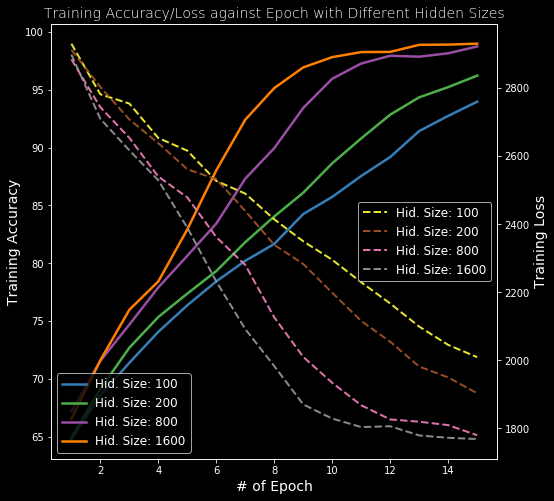

In [71]:
# plotting training accuracy and loss together 
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('dark_background')
epoches = range(1,16)
dt_acc = pd.DataFrame(train_acc_hidden_size)
dt_los = pd.DataFrame(train_loss_hidden_size)
fig, ax1 = plt.subplots(figsize=(8,8))
col_set = plt.get_cmap('Set1')
ax1.set_xlabel('# of Epoch', fontsize=14)
ax1.set_ylabel('Training Accuracy', fontsize=14)
num = 0 
for col in dt_acc:
    num += 1
    ax1.plot(epoches, dt_acc[col], color=col_set(num), linewidth = 2.5, alpha = 1, label = 'Hid. Size: ' + str(col))
ax1.legend(loc=3, ncol=1,fontsize =12)    
ax2 = ax1.twinx()
ax2.set_ylabel('Training Loss', fontsize=14) 
for col in dt_los:
    num += 1
    ax2.plot(epoches, dt_los[col], 'k--', color=col_set(num),linewidth = 2, alpha = 0.9, label = 'Hid. Size: ' + str(col))
ax2.legend(loc=7, ncol=1,fontsize =12)
plt.title("Training Accuracy/Loss against Epoch with Different Hidden Sizes", fontsize=14, fontweight=0, color='white')
plt.show()

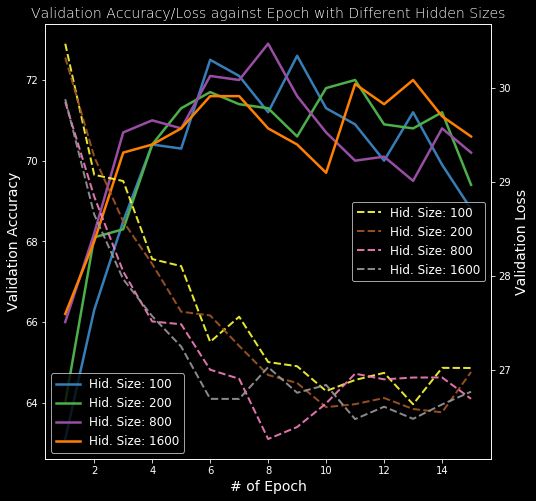

In [72]:
# validation accuracy and loss
epoches = range(1,16)
dt_acc = pd.DataFrame(val_acc_hidden_size)
dt_los = pd.DataFrame(val_loss_hidden_size)
fig, ax1 = plt.subplots(figsize=(8, 8))
col_set = plt.get_cmap('Set1')
ax1.set_xlabel('# of Epoch', fontsize=14)
ax1.set_ylabel('Validation Accuracy', fontsize=14)
num = 0 
for col in dt_acc:
    num += 1
    ax1.plot(epoches, dt_acc[col], color=col_set(num), linewidth = 2.5, alpha = 1, label = 'Hid. Size: ' + str(col))
ax1.legend(loc=3, ncol=1,fontsize =12)    
ax2 = ax1.twinx()
ax2.set_ylabel('Validation Loss', fontsize=14) 
for col in dt_los:
    num += 1
    ax2.plot(epoches, dt_los[col], 'k--', color=col_set(num),linewidth = 2, alpha = 0.9, label = 'Hid. Size: ' + str(col))
ax2.legend(loc=7, ncol=1,fontsize =12)
plt.title("Validation Accuracy/Loss against Epoch with Different Hidden Sizes", fontsize=14, fontweight=0, color='white')
plt.show()

In [4]:
num_pars

{100: 452703, 200: 933903, 800: 6341103, 1600: 20270703}

In [ ]:
train_acc_drop = {}
train_loss_drop = {}
val_acc_drop = {}
val_loss_drop = {}
num_pars_drop = {}
# get meta data for dropout vs no-dropout
for drop in [True, False]:
    epoch_acc_train = []
    epoch_loss_train = []
    epoch_acc_val = []
    epoch_loss_val = []
    model = Fc_GRU(hidden_size=800, num_layers=1, num_classes=3, Fc_dim = 300, dropout=drop)
    num_pars_drop[drop] = count_parameters(model)
    
    model = model.to(device)
    learning_rate = 3e-4
    num_epochs = 15
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        for i,(data_1, lengths_1, idx_1,data_2, lengths_2, idx_2, label) in enumerate(train_loader):
            data_1,data_2, label = data_1.to(device),data_2.to(device), label.to(device)
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data_1, lengths_1, idx_1, data_2, lengths_2, idx_2)
            loss = criterion(outputs, label)

            # Backward and optimize
            loss.backward()
            optimizer.step()
        val_acc, val_loss = test_GRU_model(val_loader , model)
        train_acc, train_loss =test_GRU_model(train_loader , model)
        epoch_acc_val.append(val_acc)
        epoch_acc_train.append(train_acc)
        epoch_loss_val.append(val_loss)
        epoch_loss_train.append(train_loss)
        print("Epoch {} done!".format(epoch))
    train_loss_drop[drop] = epoch_loss_train
    val_loss_drop[drop] = epoch_loss_val
    train_acc_drop[drop] = epoch_acc_train
    val_acc_drop[drop] = epoch_acc_val

Epoch 0 done!
Epoch 1 done!
Epoch 2 done!
Epoch 3 done!
Epoch 4 done!
Epoch 5 done!
Epoch 6 done!
Epoch 7 done!
Epoch 8 done!
Epoch 9 done!
Epoch 10 done!
Epoch 11 done!
Epoch 12 done!
Epoch 13 done!
Epoch 14 done!
Epoch 0 done!
Epoch 1 done!
Epoch 2 done!
Epoch 3 done!
Epoch 4 done!
Epoch 5 done!
Epoch 6 done!
Epoch 7 done!


In [ ]:
pickle.dump( train_acc_drop, open( "train_acc_GRU_dp.p", "wb" ) )
pickle.dump( val_acc_drop, open( "val_acc_GRU_dp.p", "wb" ) )
pickle.dump( train_loss_drop, open( "train_loss_GRU_dp.p", "wb" ) )
pickle.dump( val_loss_drop, open( "val_loss_GRU_dp.p", "wb" ) )
pickle.dump( num_pars_drop, open( "num_pars_GRU_dp.p", "wb" ) )

In [7]:
import pickle
train_acc_drop = pickle.load( open( "train_acc_GRU_dp.p", "rb" ) )
val_acc_drop = pickle.load( open( "val_acc_GRU_dp.p", "rb" ) )
train_loss_drop = pickle.load( open( "train_loss_GRU_dp.p", "rb" ) )
val_loss_drop = pickle.load( open( "val_loss_GRU_dp.p", "rb" ) )
num_pars_drop = pickle.load( open( "num_pars_GRU_dp.p", "rb" ) )

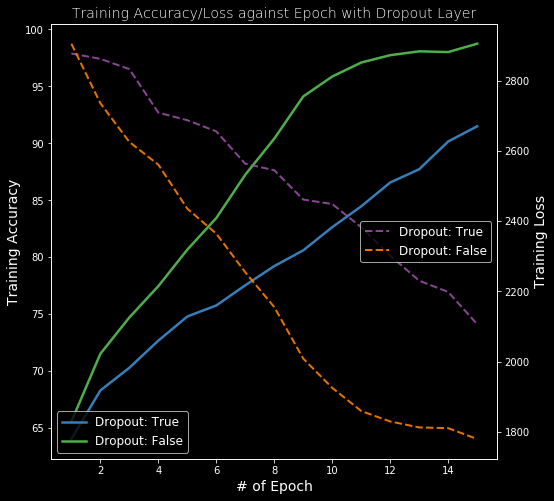

In [87]:
epoches = range(1,16)
dt_acc = pd.DataFrame(train_acc_drop)
dt_los = pd.DataFrame(train_loss_drop)
fig, ax1 = plt.subplots(figsize=(8,8))
col_set = plt.get_cmap('Set1')
ax1.set_xlabel('# of Epoch', fontsize=14)
ax1.set_ylabel('Training Accuracy', fontsize=14)
num = 0 
for col in dt_acc:
    num += 1
    ax1.plot(epoches, dt_acc[col], color=col_set(num), linewidth = 2.5, alpha = 1, label = 'Dropout: ' + str(col))
ax1.legend(loc=3, ncol=1,fontsize =12)    
ax2 = ax1.twinx()
ax2.set_ylabel('Training Loss', fontsize=14) 
for col in dt_los:
    num += 1
    ax2.plot(epoches, dt_los[col], 'k--', color=col_set(num),linewidth = 2, alpha = 0.9, label = 'Dropout: ' + str(col))
ax2.legend(loc=7, ncol=1,fontsize =12)
plt.title("Training Accuracy/Loss against Epoch with Dropout Layer", fontsize=14, fontweight=0, color='white')
plt.show()

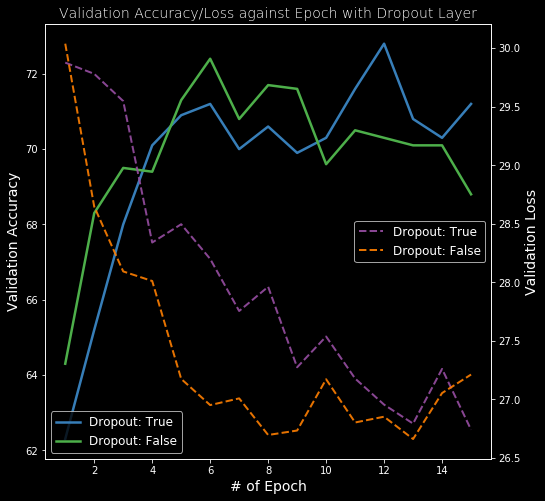

In [88]:
epoches = range(1,16)
dt_acc = pd.DataFrame(val_acc_drop)
dt_los = pd.DataFrame(val_loss_drop)
fig, ax1 = plt.subplots(figsize=(8, 8))
col_set = plt.get_cmap('Set1')
ax1.set_xlabel('# of Epoch', fontsize=14)
ax1.set_ylabel('Validation Accuracy', fontsize=14)
num = 0 
for col in dt_acc:
    num += 1
    ax1.plot(epoches, dt_acc[col], color=col_set(num), linewidth = 2.5, alpha = 1, label = 'Dropout: ' + str(col))
    # ax1.tick_params(axis='y', labelcolor=acc_col(num))
ax1.legend(loc=3, ncol=1,fontsize =12)    
ax2 = ax1.twinx()
ax2.set_ylabel('Validation Loss', fontsize=14) 
for col in dt_los:
    num += 1
    ax2.plot(epoches, dt_los[col], 'k--', color=col_set(num),linewidth = 2, alpha = 0.9, label = 'Dropout: ' + str(col))
ax2.legend(loc=7, ncol=1,fontsize =12)
plt.title("Validation Accuracy/Loss against Epoch with Dropout Layer", fontsize=14, fontweight=0, color='white')
plt.show()

In [10]:
num_pars_drop

{True: 6341103, False: 6341103}

In [33]:
train_acc_decay = {}
train_loss_decay = {}
val_acc_decay = {}
val_loss_decay = {}
num_pars_decay = {}
# try different L2 penalty
for decay in [1e-6, 2e-5, 2e-4]:
    epoch_acc_train = []
    epoch_loss_train = []
    epoch_acc_val = []
    epoch_loss_val = []
    model = Fc_GRU(hidden_size=800, num_layers=1, num_classes=3, Fc_dim = 300, dropout=True)
    num_pars_decay[decay] = count_parameters(model)
    
    model = model.to(device)
    learning_rate = 3e-4
    num_epochs = 15
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = decay)
    for epoch in range(num_epochs):
        for i,(data_1, lengths_1, idx_1,data_2, lengths_2, idx_2, label) in enumerate(train_loader):
            data_1,data_2, label = data_1.to(device),data_2.to(device), label.to(device)
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data_1, lengths_1, idx_1, data_2, lengths_2, idx_2)
            loss = criterion(outputs, label)

            # Backward and optimize
            loss.backward()
            optimizer.step()
        val_acc, val_loss = test_GRU_model(val_loader , model)
        train_acc, train_loss =test_GRU_model(train_loader , model)
        epoch_acc_val.append(val_acc)
        epoch_acc_train.append(train_acc)
        epoch_loss_val.append(val_loss)
        epoch_loss_train.append(train_loss)
        print("Epoch {} done!".format(epoch))
    train_loss_decay[decay] = epoch_loss_train
    val_loss_decay[decay] = epoch_loss_val
    train_acc_decay[decay] = epoch_acc_train
    val_acc_decay[decay] = epoch_acc_val

Epoch 0 done!
Epoch 1 done!
Epoch 2 done!
Epoch 3 done!
Epoch 4 done!
Epoch 5 done!
Epoch 6 done!
Epoch 7 done!
Epoch 8 done!
Epoch 9 done!
Epoch 10 done!
Epoch 11 done!
Epoch 12 done!
Epoch 13 done!
Epoch 14 done!
Epoch 0 done!
Epoch 1 done!
Epoch 2 done!
Epoch 3 done!
Epoch 4 done!
Epoch 5 done!
Epoch 6 done!
Epoch 7 done!
Epoch 8 done!
Epoch 9 done!
Epoch 10 done!
Epoch 11 done!
Epoch 12 done!
Epoch 13 done!
Epoch 14 done!
Epoch 0 done!
Epoch 1 done!
Epoch 2 done!
Epoch 3 done!
Epoch 4 done!
Epoch 5 done!
Epoch 6 done!
Epoch 7 done!
Epoch 8 done!
Epoch 9 done!
Epoch 10 done!
Epoch 11 done!
Epoch 12 done!
Epoch 13 done!
Epoch 14 done!


In [34]:
pickle.dump( train_acc_decay, open( "train_acc_GRU_decay.p", "wb" ) )
pickle.dump( val_acc_decay, open( "val_acc_GRU_decay.p", "wb" ) )
pickle.dump( train_loss_decay, open( "train_loss_GRU_decay.p", "wb" ) )
pickle.dump( val_loss_decay, open( "val_loss_GRU_decay.p", "wb" ) )
pickle.dump( num_pars_decay, open( "num_pars_GRU_decay.p", "wb" ) )

In [11]:
train_acc_decay = pickle.load( open( "train_acc_GRU_decay.p", "rb" ) )
val_acc_decay = pickle.load( open( "val_acc_GRU_decay.p", "rb" ) )
train_loss_decay = pickle.load( open( "train_loss_GRU_decay.p", "rb" ) )
val_loss_decay = pickle.load( open( "val_loss_GRU_decay.p", "rb" ) )
num_pars_decay = pickle.load( open( "num_pars_GRU_decay.p", "rb" ) )

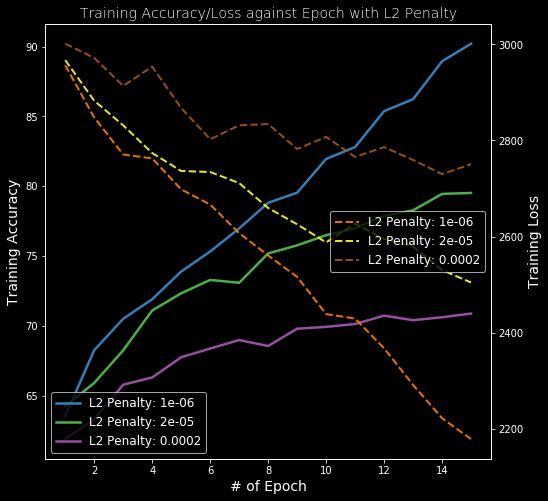

In [89]:
epoches = range(1,16)
dt_acc = pd.DataFrame(train_acc_decay)
dt_los = pd.DataFrame(train_loss_decay)
fig, ax1 = plt.subplots(figsize=(8,8))
col_set = plt.get_cmap('Set1')
ax1.set_xlabel('# of Epoch', fontsize=14)
ax1.set_ylabel('Training Accuracy', fontsize=14)
num = 0 
for col in dt_acc:
    num += 1
    ax1.plot(epoches, dt_acc[col], color=col_set(num), linewidth = 2.5, alpha = 1, label = 'L2 Penalty: ' + str(col))
ax1.legend(loc=3, ncol=1,fontsize =12)  
ax2 = ax1.twinx()
ax2.set_ylabel('Training Loss', fontsize=14) 
for col in dt_los:
    num += 1
    ax2.plot(epoches, dt_los[col], 'k--', color=col_set(num),linewidth = 2, alpha = 0.9, label = 'L2 Penalty: ' + str(col))
ax2.legend(loc=7, ncol=1,fontsize =12)
plt.title("Training Accuracy/Loss against Epoch with L2 Penalty", fontsize=14, fontweight=0, color='white')
plt.show()

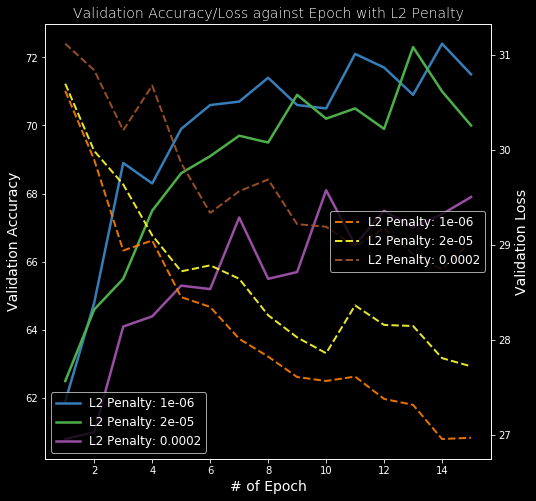

In [90]:
epoches = range(1,16)
dt_acc = pd.DataFrame(val_acc_decay)
dt_los = pd.DataFrame(val_loss_decay)
fig, ax1 = plt.subplots(figsize=(8, 8))
col_set = plt.get_cmap('Set1')
ax1.set_xlabel('# of Epoch', fontsize=14)
ax1.set_ylabel('Validation Accuracy', fontsize=14)
num = 0 
for col in dt_acc:
    num += 1
    ax1.plot(epoches, dt_acc[col], color=col_set(num), linewidth = 2.5, alpha = 1, label = 'L2 Penalty: ' + str(col))
    # ax1.tick_params(axis='y', labelcolor=acc_col(num))
ax1.legend(loc=3, ncol=1,fontsize =12)    
ax2 = ax1.twinx()
ax2.set_ylabel('Validation Loss', fontsize=14) 
for col in dt_los:
    num += 1
    ax2.plot(epoches, dt_los[col], 'k--', color=col_set(num),linewidth = 2, alpha = 0.9, label = 'L2 Penalty: ' + str(col))
ax2.legend(loc=7, ncol=1,fontsize =12)
plt.title("Validation Accuracy/Loss against Epoch with L2 Penalty", fontsize=14, fontweight=0, color='white')
plt.show()

In [15]:
num_pars_decay

{1e-06: 6341103, 2e-05: 6341103, 0.0002: 6341103}

In [45]:
train_acc_int = {}
train_loss_int = {}
val_acc_int = {}
val_loss_int = {}
num_pars_int = {}
# try interaction 
for interact in [True, False]:
    epoch_acc_train = []
    epoch_loss_train = []
    epoch_acc_val = []
    epoch_loss_val = []
    model = Fc_GRU(hidden_size=800, num_layers=1, num_classes=3, Fc_dim = 300, dropout=True, interact=interact)
    num_pars_int[interact] = count_parameters(model)
    
    model = model.to(device)
    learning_rate = 3e-4
    num_epochs = 15
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-6)
    for epoch in range(num_epochs):
        for i,(data_1, lengths_1, idx_1,data_2, lengths_2, idx_2, label) in enumerate(train_loader):
            data_1,data_2, label = data_1.to(device),data_2.to(device), label.to(device)
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data_1, lengths_1, idx_1, data_2, lengths_2, idx_2)
            loss = criterion(outputs, label)

            # Backward and optimize
            loss.backward()
            optimizer.step()
        val_acc, val_loss = test_GRU_model(val_loader , model)
        train_acc, train_loss =test_GRU_model(train_loader , model)
        epoch_acc_val.append(val_acc)
        epoch_acc_train.append(train_acc)
        epoch_loss_val.append(val_loss)
        epoch_loss_train.append(train_loss)
        print("Epoch {} done!".format(epoch))
    train_loss_int[interact] = epoch_loss_train
    val_loss_int[interact] = epoch_loss_val
    train_acc_int[interact] = epoch_acc_train
    val_acc_int[interact] = epoch_acc_val

Epoch 0 done!
Epoch 1 done!
Epoch 2 done!
Epoch 3 done!
Epoch 4 done!
Epoch 5 done!
Epoch 6 done!
Epoch 7 done!
Epoch 8 done!
Epoch 9 done!
Epoch 10 done!
Epoch 11 done!
Epoch 12 done!
Epoch 13 done!
Epoch 14 done!
Epoch 0 done!
Epoch 1 done!
Epoch 2 done!
Epoch 3 done!
Epoch 4 done!
Epoch 5 done!
Epoch 6 done!
Epoch 7 done!
Epoch 8 done!
Epoch 9 done!
Epoch 10 done!
Epoch 11 done!
Epoch 12 done!
Epoch 13 done!
Epoch 14 done!


In [46]:
pickle.dump( train_acc_int, open( "train_acc_GRU_int.p", "wb" ) )
pickle.dump( val_acc_int, open( "val_acc_GRU_int.p", "wb" ) )
pickle.dump( train_loss_int, open( "train_loss_GRU_int.p", "wb" ) )
pickle.dump( val_loss_int, open( "val_loss_GRU_int.p", "wb" ) )
pickle.dump( num_pars_int, open( "num_pars_GRU_int.p", "wb" ) )

In [16]:
train_acc_int = pickle.load( open( "train_acc_GRU_int.p", "rb" ) )
val_acc_int = pickle.load( open( "val_acc_GRU_int.p", "rb" ) )
train_loss_int = pickle.load( open( "train_loss_GRU_int.p", "rb" ) )
val_loss_int = pickle.load( open( "val_loss_GRU_int.p", "rb" ) )
num_pars_int = pickle.load( open( "num_pars_GRU_int.p", "rb" ) )

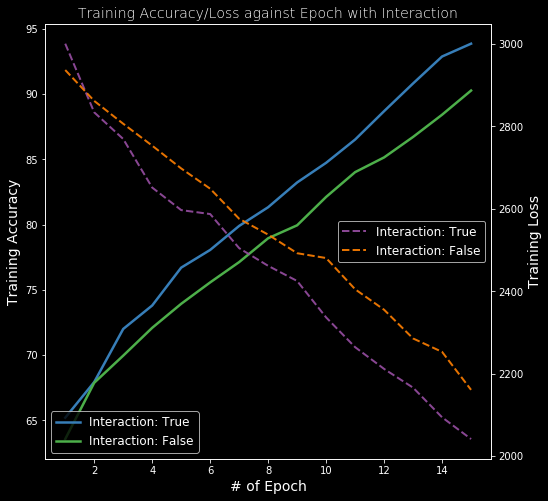

In [91]:
epoches = range(1,16)
dt_acc = pd.DataFrame(train_acc_int)
dt_los = pd.DataFrame(train_loss_int)
fig, ax1 = plt.subplots(figsize=(8,8))
col_set = plt.get_cmap('Set1')
ax1.set_xlabel('# of Epoch', fontsize=14)
ax1.set_ylabel('Training Accuracy', fontsize=14)
num = 0 
for col in dt_acc:
    num += 1
    ax1.plot(epoches, dt_acc[col], color=col_set(num), linewidth = 2.5, alpha = 1, label = 'Interaction: ' + str(col))
ax1.legend(loc=3, ncol=1,fontsize =12)  
ax2 = ax1.twinx()
ax2.set_ylabel('Training Loss', fontsize=14) 
for col in dt_los:
    num += 1
    ax2.plot(epoches, dt_los[col], 'k--', color=col_set(num),linewidth = 2, alpha = 0.9, label = 'Interaction: ' + str(col))
ax2.legend(loc=7, ncol=1,fontsize =12)
plt.title("Training Accuracy/Loss against Epoch with Interaction", fontsize=14, fontweight=0, color='white')
plt.show()

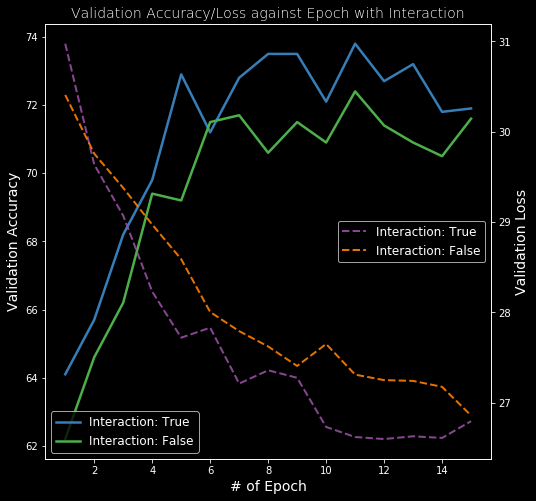

In [92]:
epoches = range(1,16)
dt_acc = pd.DataFrame(val_acc_int)
dt_los = pd.DataFrame(val_loss_int)
fig, ax1 = plt.subplots(figsize=(8, 8))
col_set = plt.get_cmap('Set1')
ax1.set_xlabel('# of Epoch', fontsize=14)
ax1.set_ylabel('Validation Accuracy', fontsize=14)
num = 0 
for col in dt_acc:
    num += 1
    ax1.plot(epoches, dt_acc[col], color=col_set(num), linewidth = 2.5, alpha = 1, label = 'Interaction: ' + str(col))
    # ax1.tick_params(axis='y', labelcolor=acc_col(num))
ax1.legend(loc=3, ncol=1,fontsize =12)    
ax2 = ax1.twinx()
ax2.set_ylabel('Validation Loss', fontsize=14) 
for col in dt_los:
    num += 1
    ax2.plot(epoches, dt_los[col], 'k--', color=col_set(num),linewidth = 2, alpha = 0.9, label = 'Interaction: ' + str(col))
ax2.legend(loc=7, ncol=1,fontsize =12)
plt.title("Validation Accuracy/Loss against Epoch with Interaction", fontsize=14, fontweight=0, color='white')
plt.show()

In [20]:
num_pars_int

{True: 6821103, False: 6341103}

In [115]:
class CNN(nn.Module):
    def __init__(self, hidden_size, num_layers = 2, k_size = 3, num_classes =3 , emb_size =300):

        super(CNN, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        # first convolute layer, consists of a 1-D convolute and a non-linear relu
        self.conv1 = nn.Sequential(
            nn.Conv1d(emb_size, hidden_size, kernel_size=k_size, padding=1),
            nn.ReLU(inplace=True)
            )
        self.conv2 = nn.Sequential(
            nn.Conv1d(hidden_size, hidden_size, kernel_size=k_size, padding=1),
            nn.ReLU(inplace=True)
            )

    def forward(self, data, idx):
        # we still need idx to unsort our sorted data
        batch_size, seq_len = data.size()
        # since CNN encoder does not need inputs in sorted order, we first unsort our data
        reverse_idx = inverse(idx)
        data = data[reverse_idx]
        # manually embed our data using pre-trained w2v
        embed = prep_emb_layer(data, vecs)
        embed = embed.to(device)
        embed = embed.transpose(1,2).contiguous()
        hidden = self.conv1(embed)        
        hidden = self.conv2(hidden) 
        # max-pooling
        return torch.max(hidden, 2)[0]

class Fc_CNN(nn.Module):
    def __init__(self, hidden_size, num_layers, Fc_dim, k_size = 3, num_classes =3, dropout=False, interact = False):
        super(Fc_CNN, self).__init__()
        self.interact = interact
        self.encoder = CNN(hidden_size, num_layers, k_size = k_size)
        
        # interaction will result in a different dimension 
        inputdim = 2*hidden_size
        if interact:
            inputdim = 3*hidden_size
        if not dropout:
            self.fc = nn.Sequential(
                    nn.Linear(inputdim, Fc_dim),
                    nn.ReLU(),
                    nn.Linear(Fc_dim, Fc_dim),
                    nn.ReLU(),
                    nn.Linear(Fc_dim, num_classes)
                    )
        else:
            self.fc = nn.Sequential(
                    nn.Dropout(),
                    nn.Linear(inputdim, Fc_dim),
                    nn.ReLU(),
                    nn.Dropout(),
                    nn.Linear(Fc_dim, Fc_dim),
                    nn.ReLU(),
                    nn.Dropout(),
                    nn.Linear(Fc_dim, num_classes)
                    )

    def forward(self, s1, idx1, s2, idx2):
        s1 = self.encoder(s1, idx1)
        s2 = self.encoder(s2, idx2)
        # similar interaction as we did for GRU
        if self.interact:
            cat = torch.cat((s1,s1*s2, s2), 1)
        else:
            cat = torch.cat((s1, s2), 1)
        logits = self.fc(cat)
        return logits

In [116]:
def test_CNN_model(data, model):
    """
    Help function that tests CNN model's performance on a dataset
    """
    correct = 0
    total = 0
    total_loss = 0 
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    for (data_1, lengths_1, idx_1,data_2, lengths_2, idx_2, label) in data:
        data_1,data_2, label = data_1.to(device),data_2.to(device), label.to(device)
        outputs = F.softmax(model(data_1, idx_1, data_2, idx_2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        total_loss += criterion(outputs, label).item()
        total += label.size(0)
        correct += predicted.eq(label.view_as(predicted)).sum().item()
    return (100 * correct / total), total_loss 

In [40]:
train_acc_hidden_size_cnn = {}
train_loss_hidden_size_cnn = {}
val_acc_hidden_size_cnn = {}
val_loss_hidden_size_cnn = {}
num_pars_cnn = {}
# explore hidden size for CNN encoder
for hid_size in [100, 300, 1200, 2400]:
    epoch_acc_train = []
    epoch_loss_train = []
    epoch_acc_val = []
    epoch_loss_val = []
    model = Fc_CNN(hidden_size=hid_size, num_layers=2, num_classes=3, Fc_dim = 300, dropout=False)
    num_pars_cnn[hid_size] = count_parameters(model)
    
    model = model.to(device)
    learning_rate = 3e-4
    num_epochs = 15
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        for i,(data_1, lengths_1, idx_1,data_2, lengths_2, idx_2, label) in enumerate(train_loader):
            data_1,data_2, label = data_1.to(device),data_2.to(device), label.to(device)
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data_1, idx_1, data_2, idx_2)
            loss = criterion(outputs, label)

            # Backward and optimize
            loss.backward()
            optimizer.step()
        val_acc, val_loss = test_CNN_model(val_loader , model)
        train_acc, train_loss =test_CNN_model(train_loader , model)
        epoch_acc_val.append(val_acc)
        epoch_acc_train.append(train_acc)
        epoch_loss_val.append(val_loss)
        epoch_loss_train.append(train_loss)
        print("Epoch {} done!".format(epoch))
    train_loss_hidden_size_cnn[hid_size] = epoch_loss_train
    val_loss_hidden_size_cnn[hid_size] = epoch_loss_val
    train_acc_hidden_size_cnn[hid_size] = epoch_acc_train
    val_acc_hidden_size_cnn[hid_size] = epoch_acc_val

Epoch 0 done!
Epoch 1 done!
Epoch 2 done!
Epoch 3 done!
Epoch 4 done!
Epoch 5 done!
Epoch 6 done!
Epoch 7 done!
Epoch 8 done!
Epoch 9 done!
Epoch 10 done!
Epoch 11 done!
Epoch 12 done!
Epoch 13 done!
Epoch 14 done!
Epoch 0 done!
Epoch 1 done!
Epoch 2 done!
Epoch 3 done!
Epoch 4 done!
Epoch 5 done!
Epoch 6 done!
Epoch 7 done!
Epoch 8 done!
Epoch 9 done!
Epoch 10 done!
Epoch 11 done!
Epoch 12 done!
Epoch 13 done!
Epoch 14 done!
Epoch 0 done!
Epoch 1 done!
Epoch 2 done!
Epoch 3 done!
Epoch 4 done!
Epoch 5 done!
Epoch 6 done!
Epoch 7 done!
Epoch 8 done!
Epoch 9 done!
Epoch 10 done!
Epoch 11 done!
Epoch 12 done!
Epoch 13 done!
Epoch 14 done!
Epoch 0 done!
Epoch 1 done!
Epoch 2 done!
Epoch 3 done!
Epoch 4 done!
Epoch 5 done!
Epoch 6 done!
Epoch 7 done!
Epoch 8 done!
Epoch 9 done!
Epoch 10 done!
Epoch 11 done!
Epoch 12 done!
Epoch 13 done!
Epoch 14 done!


In [41]:
pickle.dump( train_acc_hidden_size_cnn, open( "train_acc_CNN_hdn.p", "wb" ) )
pickle.dump( val_acc_hidden_size_cnn, open( "val_acc_CNN_hdn.p", "wb" ) )
pickle.dump( train_loss_hidden_size_cnn, open( "train_loss_CNN_hdn.p", "wb" ) )
pickle.dump( val_loss_hidden_size_cnn, open( "val_loss_CNN_hdn.p", "wb" ) )
pickle.dump( num_pars_cnn, open( "num_pars_CNN_hdn.p", "wb" ) )

In [21]:
train_acc_hidden_size_cnn = pickle.load( open( "train_acc_CNN_hdn.p", "rb" ) )
val_acc_hidden_size_cnn = pickle.load( open( "val_acc_CNN_hdn.p", "rb" ) )
train_loss_hidden_size_cnn = pickle.load( open( "train_loss_CNN_hdn.p", "rb" ) )
val_loss_hidden_size_cnn = pickle.load( open( "val_loss_CNN_hdn.p", "rb" ) )
num_pars_cnn = pickle.load( open( "num_pars_CNN_hdn.p", "rb" ) )

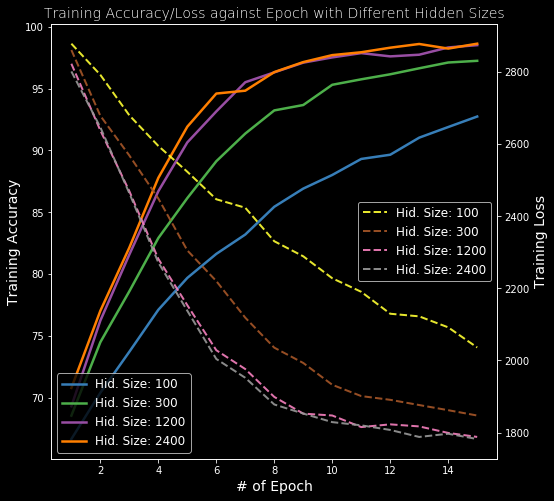

In [79]:
epoches = range(1,16)
dt_acc = pd.DataFrame(train_acc_hidden_size_cnn)
dt_los = pd.DataFrame(train_loss_hidden_size_cnn)
fig, ax1 = plt.subplots(figsize=(8,8))
col_set = plt.get_cmap('Set1')
ax1.set_xlabel('# of Epoch', fontsize=14)
ax1.set_ylabel('Training Accuracy', fontsize=14)
num = 0 
for col in dt_acc:
    num += 1
    ax1.plot(epoches, dt_acc[col], color=col_set(num), linewidth = 2.5, alpha = 1, label = 'Hid. Size: ' + str(col))
ax1.legend(loc=3, ncol=1,fontsize =12)    
ax2 = ax1.twinx()
ax2.set_ylabel('Training Loss', fontsize=14) 
for col in dt_los:
    num += 1
    ax2.plot(epoches, dt_los[col], 'k--', color=col_set(num),linewidth = 2, alpha = 0.9, label = 'Hid. Size: ' + str(col))
ax2.legend(loc=7, ncol=1,fontsize =12)
plt.title("Training Accuracy/Loss against Epoch with Different Hidden Sizes", fontsize=14, fontweight=0, color='white')
plt.show()

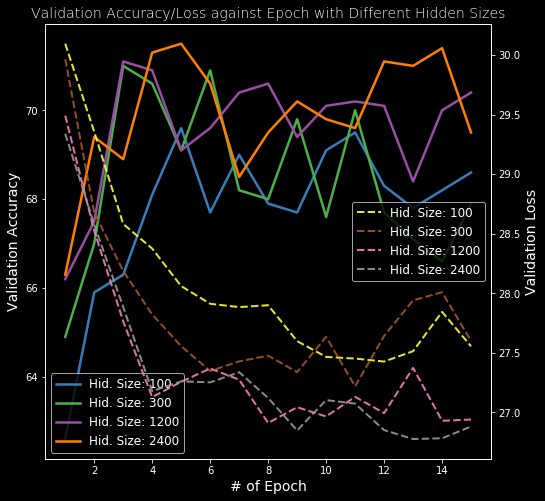

In [80]:
epoches = range(1,16)
dt_acc = pd.DataFrame(val_acc_hidden_size_cnn)
dt_los = pd.DataFrame(val_loss_hidden_size_cnn)
fig, ax1 = plt.subplots(figsize=(8, 8))
col_set = plt.get_cmap('Set1')
ax1.set_xlabel('# of Epoch', fontsize=14)
ax1.set_ylabel('Validation Accuracy', fontsize=14)
num = 0 
for col in dt_acc:
    num += 1
    ax1.plot(epoches, dt_acc[col], color=col_set(num), linewidth = 2.5, alpha = 1, label = 'Hid. Size: ' + str(col))
ax1.legend(loc=3, ncol=1,fontsize =12)    
ax2 = ax1.twinx()
ax2.set_ylabel('Validation Loss', fontsize=14) 
for col in dt_los:
    num += 1
    ax2.plot(epoches, dt_los[col], 'k--', color=col_set(num),linewidth = 2, alpha = 0.9, label = 'Hid. Size: ' + str(col))
ax2.legend(loc=7, ncol=1,fontsize =12)
plt.title("Validation Accuracy/Loss against Epoch with Different Hidden Sizes", fontsize=14, fontweight=0, color='white')
plt.show()

In [24]:
num_pars_cnn

{100: 271703, 300: 812103, 1200: 6213903, 2400: 20976303}

In [90]:
train_acc_k_size_cnn = {}
train_loss_k_size_cnn = {}
val_acc_k_size_cnn = {}
val_loss_k_size_cnn = {}
num_pars_k_size_cnn = {}
# tune kernel size
for k_size in [1, 2, 3]:
    epoch_acc_train = []
    epoch_loss_train = []
    epoch_acc_val = []
    epoch_loss_val = []
    model = Fc_CNN(hidden_size=1200, num_layers=2, num_classes=3, Fc_dim = 300, k_size = k_size, dropout=False)
    num_pars_k_size_cnn[k_size] = count_parameters(model)
    
    model = model.to(device)
    learning_rate = 3e-4
    num_epochs = 15
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i,(data_1, lengths_1, idx_1,data_2, lengths_2, idx_2, label) in enumerate(train_loader):
            data_1,data_2, label = data_1.to(device),data_2.to(device), label.to(device)
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data_1, idx_1, data_2, idx_2)
            loss = criterion(outputs, label)

            # Backward and optimize
            loss.backward()
            optimizer.step()
        val_acc, val_loss = test_CNN_model(val_loader , model)
        train_acc, train_loss =test_CNN_model(train_loader , model)
        epoch_acc_val.append(val_acc)
        epoch_acc_train.append(train_acc)
        epoch_loss_val.append(val_loss)
        epoch_loss_train.append(train_loss)
        print("Epoch {} done!".format(epoch))
    train_loss_k_size_cnn[k_size] = epoch_loss_train
    val_loss_k_size_cnn[k_size] = epoch_loss_val
    train_acc_k_size_cnn[k_size] = epoch_acc_train
    val_acc_k_size_cnn[k_size] = epoch_acc_val

Epoch 0 done!
Epoch 1 done!
Epoch 2 done!
Epoch 3 done!
Epoch 4 done!
Epoch 5 done!
Epoch 6 done!
Epoch 7 done!
Epoch 8 done!
Epoch 9 done!
Epoch 10 done!
Epoch 11 done!
Epoch 12 done!
Epoch 13 done!
Epoch 14 done!
Epoch 0 done!
Epoch 1 done!
Epoch 2 done!
Epoch 3 done!
Epoch 4 done!
Epoch 5 done!
Epoch 6 done!
Epoch 7 done!
Epoch 8 done!
Epoch 9 done!
Epoch 10 done!
Epoch 11 done!
Epoch 12 done!
Epoch 13 done!
Epoch 14 done!
Epoch 0 done!
Epoch 1 done!
Epoch 2 done!
Epoch 3 done!
Epoch 4 done!
Epoch 5 done!
Epoch 6 done!
Epoch 7 done!
Epoch 8 done!
Epoch 9 done!
Epoch 10 done!
Epoch 11 done!
Epoch 12 done!
Epoch 13 done!
Epoch 14 done!


In [91]:
pickle.dump( train_acc_k_size_cnn, open( "train_acc_CNN_ker.p", "wb" ) )
pickle.dump( val_acc_k_size_cnn, open( "val_acc_CNN_ker.p", "wb" ) )
pickle.dump( train_loss_k_size_cnn, open( "train_loss_CNN_ker.p", "wb" ) )
pickle.dump( val_loss_k_size_cnn, open( "val_loss_CNN_ker.p", "wb" ) )
pickle.dump( num_pars_k_size_cnn, open( "num_pars_CNN_ker.p", "wb" ) )

In [25]:
train_acc_k_size_cnn = pickle.load( open( "train_acc_CNN_ker.p", "rb" ) )
val_acc_k_size_cnn = pickle.load( open( "val_acc_CNN_ker.p", "rb" ) )
train_loss_k_size_cnn = pickle.load( open( "train_loss_CNN_ker.p", "rb" ) )
val_loss_k_size_cnn = pickle.load( open( "val_loss_CNN_ker.p", "rb" ) )
num_pars_k_size_cnn = pickle.load( open( "num_pars_CNN_ker.p", "rb" ) )

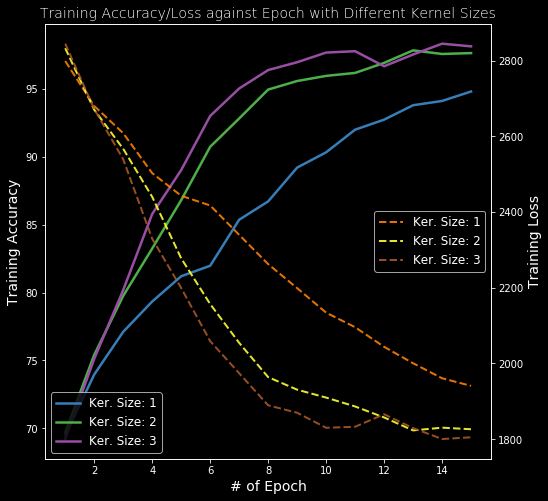

In [81]:
epoches = range(1,16)
dt_acc = pd.DataFrame(train_acc_k_size_cnn)
dt_los = pd.DataFrame(train_loss_k_size_cnn)
fig, ax1 = plt.subplots(figsize=(8,8))
col_set = plt.get_cmap('Set1')
ax1.set_xlabel('# of Epoch', fontsize=14)
ax1.set_ylabel('Training Accuracy', fontsize=14)
num = 0 
for col in dt_acc:
    num += 1
    ax1.plot(epoches, dt_acc[col], color=col_set(num), linewidth = 2.5, alpha = 1, label = 'Ker. Size: ' + str(col))
ax1.legend(loc=3, ncol=1,fontsize =12)    
ax2 = ax1.twinx()
ax2.set_ylabel('Training Loss', fontsize=14) 
for col in dt_los:
    num += 1
    ax2.plot(epoches, dt_los[col], 'k--', color=col_set(num),linewidth = 2, alpha = 0.9, label = 'Ker. Size: ' + str(col))
ax2.legend(loc=7, ncol=1,fontsize =12)
plt.title("Training Accuracy/Loss against Epoch with Different Kernel Sizes", fontsize=14, fontweight=0, color='white')
#fig.tight_layout()
plt.show()

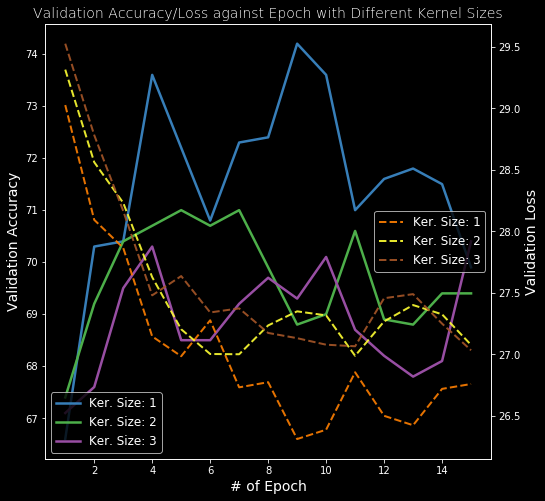

In [82]:
epoches = range(1,16)
dt_acc = pd.DataFrame(val_acc_k_size_cnn)
dt_los = pd.DataFrame(val_loss_k_size_cnn)
fig, ax1 = plt.subplots(figsize=(8, 8))
col_set = plt.get_cmap('Set1')
ax1.set_xlabel('# of Epoch', fontsize=14)
ax1.set_ylabel('Validation Accuracy', fontsize=14)
num = 0 
for col in dt_acc:
    num += 1
    ax1.plot(epoches, dt_acc[col], color=col_set(num), linewidth = 2.5, alpha = 1, label = 'Ker. Size: ' + str(col))
ax1.legend(loc=3, ncol=1,fontsize =12)    
ax2 = ax1.twinx()
ax2.set_ylabel('Validation Loss', fontsize=14) 
for col in dt_los:
    num += 1
    ax2.plot(epoches, dt_los[col], 'k--', color=col_set(num),linewidth = 2, alpha = 0.9, label = 'Ker. Size: ' + str(col))
ax2.legend(loc=7, ncol=1,fontsize =12)
plt.title("Validation Accuracy/Loss against Epoch with Different Kernel Sizes", fontsize=14, fontweight=0, color='white')
plt.show()

In [31]:
num_pars_k_size_cnn

{1: 2613903, 2: 4413903, 3: 6213903}

In [ ]:
train_acc_int_cnn = {}
train_loss_int_cnn = {}
val_acc_int_cnn = {}
val_loss_int_cnn = {}
num_pars_int_cnn = {}
for interact in [True, False]:
    epoch_acc_train = []
    epoch_loss_train = []
    epoch_acc_val = []
    epoch_loss_val = []
    model = Fc_CNN(hidden_size=1200, num_layers=2, num_classes=3, Fc_dim = 300, k_size = 1, dropout=False, interact = interact)
    num_pars_int_cnn[interact] = count_parameters(model)
    
    model = model.to(device)
    learning_rate = 3e-4
    num_epochs = 15
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        for i,(data_1, lengths_1, idx_1,data_2, lengths_2, idx_2, label) in enumerate(train_loader):
            data_1,data_2, label = data_1.to(device),data_2.to(device), label.to(device)
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data_1, idx_1, data_2, idx_2)
            loss = criterion(outputs, label)

            # Backward and optimize
            loss.backward()
            optimizer.step()
        val_acc, val_loss = test_CNN_model(val_loader , model)
        train_acc, train_loss =test_CNN_model(train_loader , model)
        epoch_acc_val.append(val_acc)
        epoch_acc_train.append(train_acc)
        epoch_loss_val.append(val_loss)
        epoch_loss_train.append(train_loss)
        print("Epoch {} done!".format(epoch))
    train_loss_int_cnn[interact] = epoch_loss_train
    val_loss_int_cnn[interact] = epoch_loss_val
    train_acc_int_cnn[interact] = epoch_acc_train
    val_acc_int_cnn[interact] = epoch_acc_val

In [27]:
pickle.dump( train_acc_int_cnn, open( "train_acc_CNN_int.p", "wb" ) )
pickle.dump( val_acc_int_cnn, open( "val_acc_CNN_int.p", "wb" ) )
pickle.dump( train_loss_int_cnn, open( "train_loss_CNN_int.p", "wb" ) )
pickle.dump( val_loss_int_cnn, open( "val_loss_CNN_int.p", "wb" ) )
pickle.dump( num_pars_int_cnn, open( "num_pars_CNN_int.p", "wb" ) )

In [37]:
train_acc_int_cnn = pickle.load( open( "train_acc_CNN_int.p", "rb" ) )
val_acc_int_cnn = pickle.load( open( "val_acc_CNN_int.p", "rb" ) )
train_loss_int_cnn = pickle.load( open( "train_loss_CNN_int.p", "rb" ) )
val_loss_int_cnn = pickle.load( open( "val_loss_CNN_int.p", "rb" ) )
num_pars_int_cnn = pickle.load( open( "num_pars_CNN_int.p", "rb" ) )

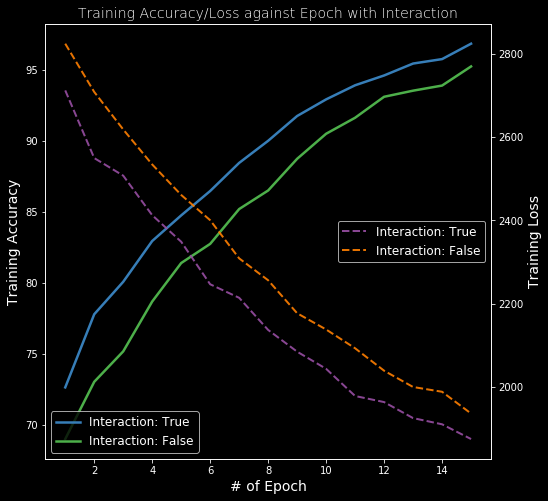

In [93]:
epoches = range(1,16)
dt_acc = pd.DataFrame(train_acc_int_cnn)
dt_los = pd.DataFrame(train_loss_int_cnn)
fig, ax1 = plt.subplots(figsize=(8,8))
col_set = plt.get_cmap('Set1')
ax1.set_xlabel('# of Epoch', fontsize=14)
ax1.set_ylabel('Training Accuracy', fontsize=14)
num = 0 
for col in dt_acc:
    num += 1
    ax1.plot(epoches, dt_acc[col], color=col_set(num), linewidth = 2.5, alpha = 1, label = 'Interaction: ' + str(col))
ax2 = ax1.twinx()
ax2.set_ylabel('Training Loss', fontsize=14) 
for col in dt_los:
    num += 1
    ax2.plot(epoches, dt_los[col], 'k--', color=col_set(num),linewidth = 2, alpha = 0.9, label = 'Interaction: ' + str(col))
ax1.legend(loc=3, ncol=1,fontsize =12)  
ax2.legend(loc=7, ncol=1,fontsize =12)
plt.title("Training Accuracy/Loss against Epoch with Interaction", fontsize=14, fontweight=0, color='white')
plt.show()

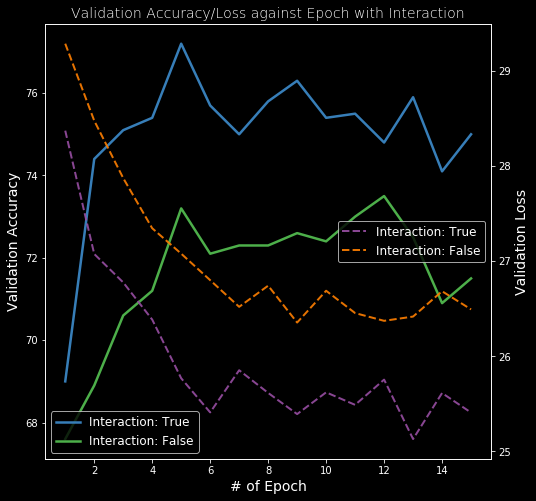

In [98]:
epoches = range(1,16)
dt_acc = pd.DataFrame(val_acc_int_cnn)
dt_los = pd.DataFrame(val_loss_int_cnn)
fig, ax1 = plt.subplots(figsize=(8,8))
col_set = plt.get_cmap('Set1')
ax1.set_xlabel('# of Epoch', fontsize=14)
ax1.set_ylabel('Validation Accuracy', fontsize=14)
num = 0 
for col in dt_acc:
    num += 1
    ax1.plot(epoches, dt_acc[col], color=col_set(num), linewidth = 2.5, alpha = 1, label = 'Interaction: ' + str(col))
ax2 = ax1.twinx()
ax2.set_ylabel('Validation Loss', fontsize=14) 
for col in dt_los:
    num += 1
    ax2.plot(epoches, dt_los[col], 'k--', color=col_set(num),linewidth = 2, alpha = 0.9, label = 'Interaction: ' + str(col))
ax1.legend(loc=3, ncol=1,fontsize =12)  
ax2.legend(loc=7, ncol=1,fontsize =12)
plt.title("Validation Accuracy/Loss against Epoch with Interaction", fontsize=14, fontweight=0, color='white')
plt.show()

In [39]:
num_pars_int_cnn

{True: 2973903, False: 2613903}

In [108]:
train_acc_reg_cnn = {}
train_loss_reg_cnn = {}
val_acc_reg_cnn = {}
val_loss_reg_cnn = {}
num_pars_reg_cnn = {}
# here we only try dropout
for reg in [True, False]:
    epoch_acc_train = []
    epoch_loss_train = []
    epoch_acc_val = []
    epoch_loss_val = []
    model = Fc_CNN(hidden_size=1200, num_layers=2, num_classes=3, Fc_dim = 300, k_size = 1, dropout=reg, interact = True)
    num_pars_reg_cnn[reg] = count_parameters(model)
    
    model = model.to(device)
    learning_rate = 3e-4
    num_epochs = 20
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-6)
    for epoch in range(num_epochs):
        for i,(data_1, lengths_1, idx_1,data_2, lengths_2, idx_2, label) in enumerate(train_loader):
            data_1,data_2, label = data_1.to(device),data_2.to(device), label.to(device)
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data_1, idx_1, data_2, idx_2)
            loss = criterion(outputs, label)

            # Backward and optimize
            loss.backward()
            optimizer.step()
        val_acc, val_loss = test_CNN_model(val_loader , model)
        train_acc, train_loss =test_CNN_model(train_loader , model)
        epoch_acc_val.append(val_acc)
        epoch_acc_train.append(train_acc)
        epoch_loss_val.append(val_loss)
        epoch_loss_train.append(train_loss)
        print("Epoch {} done!".format(epoch))
    train_loss_reg_cnn[reg] = epoch_loss_train
    val_loss_reg_cnn[reg] = epoch_loss_val
    train_acc_reg_cnn[reg] = epoch_acc_train
    val_acc_reg_cnn[reg] = epoch_acc_val
    

Epoch 0 done!
Epoch 1 done!
Epoch 2 done!
Epoch 3 done!
Epoch 4 done!
Epoch 5 done!
Epoch 6 done!
Epoch 7 done!
Epoch 8 done!
Epoch 9 done!
Epoch 10 done!
Epoch 11 done!
Epoch 12 done!
Epoch 13 done!
Epoch 14 done!
Epoch 15 done!
Epoch 16 done!
Epoch 17 done!
Epoch 18 done!
Epoch 19 done!
Epoch 0 done!
Epoch 1 done!
Epoch 2 done!
Epoch 3 done!
Epoch 4 done!
Epoch 5 done!
Epoch 6 done!
Epoch 7 done!
Epoch 8 done!
Epoch 9 done!
Epoch 10 done!
Epoch 11 done!
Epoch 12 done!
Epoch 13 done!
Epoch 14 done!
Epoch 15 done!
Epoch 16 done!
Epoch 17 done!
Epoch 18 done!
Epoch 19 done!


In [109]:
pickle.dump( train_acc_reg_cnn, open( "train_acc_CNN_reg.p", "wb" ) )
pickle.dump( val_acc_reg_cnn, open( "val_acc_CNN_reg.p", "wb" ) )
pickle.dump( train_loss_reg_cnn, open( "train_loss_CNN_reg.p", "wb" ) )
pickle.dump( val_loss_reg_cnn, open( "val_loss_CNN_reg.p", "wb" ) )
pickle.dump( num_pars_reg_cnn, open( "num_pars_CNN_reg.p", "wb" ) )

In [41]:
train_acc_reg_cnn = pickle.load( open( "train_acc_CNN_reg.p", "rb" ) )
val_acc_reg_cnn = pickle.load( open( "val_acc_CNN_reg.p", "rb" ) )
train_loss_reg_cnn = pickle.load( open( "train_loss_CNN_reg.p", "rb" ) )
val_loss_reg_cnn = pickle.load( open( "val_loss_CNN_reg.p", "rb" ) )
num_pars_reg_cnn = pickle.load( open( "num_pars_CNN_reg.p", "rb" ) )

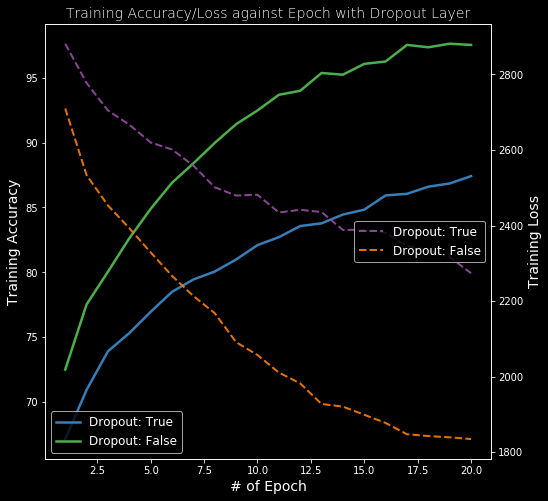

In [95]:
epoches = range(1,21)
dt_acc = pd.DataFrame(train_acc_reg_cnn)
dt_los = pd.DataFrame(train_loss_reg_cnn)
fig, ax1 = plt.subplots(figsize=(8,8))
col_set = plt.get_cmap('Set1')
ax1.set_xlabel('# of Epoch', fontsize=14)
ax1.set_ylabel('Training Accuracy', fontsize=14)
num = 0 
for col in dt_acc:
    num += 1
    ax1.plot(epoches, dt_acc[col], color=col_set(num), linewidth = 2.5, alpha = 1, label = 'Dropout: ' + str(col))
ax2 = ax1.twinx()
ax2.set_ylabel('Training Loss', fontsize=14) 
for col in dt_los:
    num += 1
    ax2.plot(epoches, dt_los[col], 'k--', color=col_set(num),linewidth = 2, alpha = 0.9, label = 'Dropout: ' + str(col))
ax1.legend(loc=3, ncol=1,fontsize =12)  
ax2.legend(loc=7, ncol=1,fontsize =12)
plt.title("Training Accuracy/Loss against Epoch with Dropout Layer", fontsize=14, fontweight=0, color='white')
plt.show()

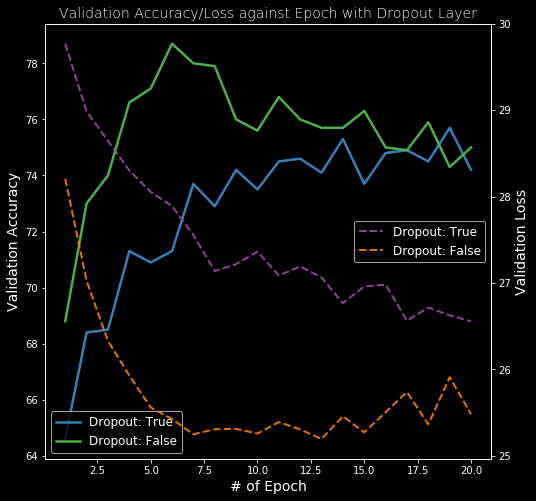

In [97]:
epoches = range(1,21)
dt_acc = pd.DataFrame(val_acc_reg_cnn)
dt_los = pd.DataFrame(val_loss_reg_cnn)
fig, ax1 = plt.subplots(figsize=(8,8))
col_set = plt.get_cmap('Set1')
ax1.set_xlabel('# of Epoch', fontsize=14)
ax1.set_ylabel('Validation Accuracy', fontsize=14)
num = 0 
for col in dt_acc:
    num += 1
    ax1.plot(epoches, dt_acc[col], color=col_set(num), linewidth = 2.5, alpha = 1, label = 'Dropout: ' + str(col))
ax2 = ax1.twinx()
ax2.set_ylabel('Validation Loss', fontsize=14) 
for col in dt_los:
    num += 1
    ax2.plot(epoches, dt_los[col], 'k--', color=col_set(num),linewidth = 2, alpha = 0.9, label = 'Dropout: ' + str(col))
ax1.legend(loc=3, ncol=1,fontsize =12)  
ax2.legend(loc=7, ncol=1,fontsize =12)
plt.title("Validation Accuracy/Loss against Epoch with Dropout Layer", fontsize=14, fontweight=0, color='white')
plt.show()

In [46]:
num_pars_reg_cnn

{True: 2973903, False: 2973903}

In [119]:
def find_best_BiGru():
    epoch_acc_train = []
    epoch_loss_train = []
    epoch_acc_val = []
    epoch_loss_val = []
    # use tuned parameter sets
    model = Fc_GRU(hidden_size=800, num_layers=1, num_classes=3, Fc_dim = 300, dropout=True, interact=True)
    
    model = model.to(device)
    learning_rate = 3e-4
    num_epochs = 15
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-6)
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i,(data_1, lengths_1, idx_1,data_2, lengths_2, idx_2, label) in enumerate(train_loader):
            data_1,data_2, label = data_1.to(device),data_2.to(device), label.to(device)
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data_1, lengths_1, idx_1, data_2, lengths_2, idx_2)
            loss = criterion(outputs, label)

            # Backward and optimize
            loss.backward()
            optimizer.step()
        val_acc, val_loss = test_GRU_model(val_loader , model)
        train_acc, train_loss =test_GRU_model(train_loader , model)
        # early stopping 
        try:
            # save best parameter sets based on validation accuracy 
            if val_acc > max(epoch_acc_val):
                torch.save(model.state_dict(), 'my_BiGRU.pth')
        except ValueError:
            torch.save(model.state_dict(), 'my_BiGRU.pth')
        epoch_acc_val.append(val_acc)
        epoch_acc_train.append(train_acc)
        epoch_loss_val.append(val_loss)
        epoch_loss_train.append(train_loss)
        print("Epoch {} done!".format(epoch))
    return epoch_acc_val, epoch_acc_train, epoch_loss_val, epoch_loss_train

In [ ]:
my_Gru_acc_val, my_Gru_acc_train, my_Gru_los_val, my_Gru_los_train = find_best_BiGru()

In [121]:
my_best_gru = Fc_GRU(hidden_size=800, num_layers=1, num_classes=3, Fc_dim = 300, dropout=True, interact=True)
my_best_gru = my_best_gru.to(device)
my_best_gru.load_state_dict(torch.load('my_BiGRU.pth'))
san_check, _ = test_GRU_model(val_loader , my_best_gru)

In [103]:
my_Gru_acc_val

[63.0,
 67.6,
 69.1,
 70.0,
 71.3,
 71.6,
 72.8,
 72.7,
 73.5,
 72.7,
 72.6,
 72.9,
 72.7,
 72.1,
 73.3]

In [133]:
def find_best_CNN():
    epoch_acc_train = []
    epoch_loss_train = []
    epoch_acc_val = []
    epoch_loss_val = []
    # use tuned parameter sets
    model = Fc_CNN(hidden_size=1200, num_layers=2, num_classes=3, Fc_dim = 300, k_size = 1, dropout=False, interact = True)
    
    model = model.to(device)
    learning_rate = 3e-4
    num_epochs = 15
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-6)
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i,(data_1, lengths_1, idx_1,data_2, lengths_2, idx_2, label) in enumerate(train_loader):
            data_1,data_2, label = data_1.to(device),data_2.to(device), label.to(device)
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data_1, idx_1, data_2, idx_2)
            loss = criterion(outputs, label)

            # Backward and optimize
            loss.backward()
            optimizer.step()
        val_acc, val_loss = test_CNN_model(val_loader , model)
        train_acc, train_loss =test_CNN_model(train_loader , model)
        # early stopping 
        try:
            # save best parameter sets based on validation accuracy 
            if val_acc > max(epoch_acc_val):
                torch.save(model.state_dict(), 'my_CNN.pth')
        except ValueError:
            torch.save(model.state_dict(), 'my_CNN.pth')
        epoch_acc_val.append(val_acc)
        epoch_acc_train.append(train_acc)
        epoch_loss_val.append(val_loss)
        epoch_loss_train.append(train_loss)
        print("Epoch {} done!".format(epoch))
    epoch_acc_val.append(val_acc)
    epoch_acc_train.append(train_acc)
    epoch_loss_val.append(val_loss)
    epoch_loss_train.append(train_loss)
    return epoch_acc_val, epoch_acc_train, epoch_loss_val, epoch_loss_train

In [134]:
my_cnn_acc_val, my_cnn_acc_train, my_cnn_los_val, my_cnn_los_train = find_best_CNN()

Epoch 0 done!
Epoch 1 done!
Epoch 2 done!
Epoch 3 done!
Epoch 4 done!
Epoch 5 done!
Epoch 6 done!
Epoch 7 done!
Epoch 8 done!
Epoch 9 done!
Epoch 10 done!
Epoch 11 done!
Epoch 12 done!
Epoch 13 done!
Epoch 14 done!


In [126]:
my_best_cnn = Fc_CNN(hidden_size=1200, num_layers=2, num_classes=3, Fc_dim = 300, k_size = 1, dropout=False, interact = True)
my_best_cnn = my_best_cnn.to(device)
my_best_cnn.load_state_dict(torch.load('my_CNN.pth'))
san_check, _ = test_CNN_model(val_loader , my_best_cnn)

In [127]:
san_check

76.2

In [151]:
def print_GRU_predictions(loader, model, m_type= 'GRU'):
    # use this function to print prediction samples
    # loader: data input 
    # model: either CNN model or GRU model
    # m_type: tell the function which model you have input
    correct = {}
    wrong = {}
    model.eval()
    for data_1, lengths_1, idx_1,data_2, lengths_2, idx_2, label in loader:
        data_1,data_2, label = \
            data_1.to(device),data_2.to(device), label.to(device)
        if m_type == 'GRU':
            # GRU model needs length information as well
            outputs = F.softmax(model(data_1, lengths_1, idx_1, data_2, lengths_2, idx_2), dim=1)
        elif m_type == 'CNN':
            outputs = F.softmax(model(data_1, idx_1, data_2, idx_2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        # unsort data insider dataloader to retain correspondences 
        data_1 = data_1[inverse(idx_1)]
        data_2 = data_2[inverse(idx_2)]
        for ind in range(32):
            # record correct indices data to the correct file
            if (predicted.tolist()[ind][0] == label.data.tolist()[ind]):
                correct[ind] = {}
                correct[ind]['s1'] = (data_1[ind].tolist())
                correct[ind]['s2'] = (data_2[ind].tolist())
                correct[ind]['lb'] = (label[ind].tolist())
            else:
                wrong[ind] = {}
                wrong[ind]['s1'] = (data_1[ind].tolist())
                wrong[ind]['s2'] = (data_2[ind].tolist())
                wrong[ind]['lb'] = (label[ind].tolist())
                # keep track of incorrect predictions 
                wrong[ind]['pred'] = (predicted.tolist()[ind][0])
        # stop when we have enough data
        if (len(correct) > 3) and (len(wrong) > 3):
            break
    return correct, wrong

In [168]:
GRU_cor, GRU_wro = print_GRU_predictions(val_loader , my_best_gru, 'GRU')

In [169]:
CNN_cor, CNN_wro = print_GRU_predictions(val_loader , my_best_cnn, 'CNN')

In [170]:
# this function converts id to words
def id_2_sentence(meta):
    s1, s2 = [], []
    # extract meaningful word indices
    for id in meta['s1']:
        # stop at padding indices
        if id == 0:
            break
        # transform indices to text
        s1.append(id2char[id])
    for id in meta['s2']:
        # stop at padding indices
        if id == 0:
            break
        # transform indices to text
        s2.append(id2char[id])
    try:
        # for wrong predictions, we print their original label and predicted label
        return [' '.join(s1)], [' '.join(s2)], ('entitlement' if meta['lb']==0 else ( 'neutral' if meta['lb']==1 else 'contradiction')), ('entitlement' if meta['pred']==0 else ( 'neutral' if meta['pred']==1 else 'contradiction'))
    except KeyError:
        # for correct preditions, we only have one label to print 
        return [' '.join(s1)], [' '.join(s2)], ('entitlement' if meta['lb']==0 else ( 'neutral' if meta['lb']==1 else 'contradiction'))
    

In [171]:
for (count,idx) in enumerate(GRU_cor):
    print(id_2_sentence(GRU_cor[idx]))

(['A young man shielding himself from a stream of water from a fire engine by using an'], ['A fire engine shoots water at a young man with an umbrella .'], 'entitlement')
(['A man in a blue helmet jumping off of a hill on a dirt bike .'], ['The man is a professional athlete .'], 'neutral')
(['A large man in white dances in the middle of a crowd holding a beverage in his'], ['Two girls crowd surf at a rave .'], 'contradiction')
(['A man with a mustache who is wearing white and beige carefully sculpts a sand castle .'], ['A man building a sand castle'], 'entitlement')
(['A girl in a red top is holding slips of paper .'], ['A girl is wearing a red top .'], 'entitlement')
(['The young girl cools off by sliding on the water slide .'], ['The girl goes down a water slide .'], 'entitlement')
(['A woman <unk> in a rural area .'], ['The woman is in great shape .'], 'neutral')
(['A man gives a speech at an ornate costume party .'], ['A public speaker is protesting Halloween .'], 'neutral')
(['A l

In [172]:
for (count,idx) in enumerate(GRU_wro):
    print(id_2_sentence(GRU_wro[idx]))

(['An older couple is resting on a bench .'], ['A couple is holding hands .'], 'neutral', 'entitlement')
(['Man in gray zippered jacket and red shirt pets a brown dog and holds a young girl'], ['A man holds a small child while petting his dog with his girlfriend is holding her son'], 'entitlement', 'neutral')
(['A baseball player sliding toward second base .'], ['A baseball player sliding toward first base .'], 'contradiction', 'neutral')
(['A group at an outdoor party includes a man wearing camouflage pants with neon orange boots and'], ['The group at the party is outside .'], 'entitlement', 'neutral')
(['A goalie is watching the action during a soccer game .'], ['The goalie is sitting in the highest bench of the stadium .'], 'neutral', 'contradiction')
(['Two women both dressed in white tops and dark-colored shorts are standing in front of some motorcycles'], ['One woman and one man stand in front of a new car while wearing green sweaters .'], 'contradiction', 'neutral')
(['Three Okl

In [173]:
for (count,idx) in enumerate(CNN_cor):
    print(id_2_sentence(CNN_cor[idx]))

(['Bald man in white and black shorts , punching man with black hair , and red ,'], ['The men are fighting over a girl .'], 'neutral')
(['Many people are in a cafeteria or restaurant , there are two workers wearing white and black'], ['A restaurant prepares for a busy day .'], 'neutral')
(['A man in a striped shirt and lady in a black hat are watching a young band'], ['A lady has a black hat .'], 'entitlement')
(['Several children are standing in a house looking out the window .'], ['some siblings are indoors while it rains'], 'neutral')
(['A woman in a blue jacket is drinking tea from a cup .'], ['A woman wearing a blue jacket is drinking tea .'], 'entitlement')
(['Two children playing on the floor with toy trains .'], ['The girls slept on the floor next to the toys .'], 'contradiction')
(['a man with a tattoo on his arm cooking something in a frying pan .'], ['A man cooks food .'], 'entitlement')
(['During this vacation children enjoying their games at the park .'], ['The park is cro

In [174]:
for (count,idx) in enumerate(CNN_wro):
    print(id_2_sentence(CNN_wro[idx]))

(['Two women , one wearing a scarf and the other wearing a broad brim hat , pound'], ['Two individuals are beating a bread dough on the table .'], 'neutral', 'contradiction')
(['Two children are sleeping while someone is <unk> through a book of music .'], ['The children are at a birthday party .'], 'contradiction', 'neutral')
(['A group of people dressed in Santa Claus suits are looking towards an audience while a DJ'], ['A DJ plays music for a crowd while they play with a green balls .'], 'entitlement', 'neutral')
(['A couple of peace <unk> workers are helping a black kid dig .'], ['The peace <unk> people are helping the black kid dig a hole to find gold .'], 'neutral', 'entitlement')


In [112]:
mul_val = pd.read_csv('mnli_val.tsv', delimiter='\t')

In [116]:
def get_acc_p_genre(model='GRU', genre_data = mul_val):
    # get column names 
    gens = genre_data['genre'].unique()
    gen_acc = {}
    for gen in gens:
        gen_data = (genre_data[genre_data['genre'] == gen]).drop(['genre'], axis=1)
        premise = []
        hyp = []
        target = []
        # prepare data for each genre
        for i in range(len(gen_data)):
            premise.append(gen_data.iloc[i]['sentence1'].split())
            hyp.append(gen_data.iloc[i]['sentence2'].split())
            target.append(gen_data.iloc[i]['label'])
        label_dcit = {'entailment': 0,  'neutral': 1, 'contradiction': 2}
        labels = []
        for label in target:
            labels.append(label_dcit[label])
        token = VocabDataset(premise, hyp, labels, char2id)
        gen_loader = torch.utils.data.DataLoader(dataset=token, batch_size=BATCH_SIZE,
                                                   collate_fn=collate_func, shuffle=True)
        # load our pre-trained model 
        if model == 'GRU':
            my_mod = Fc_GRU(hidden_size=800, num_layers=1, num_classes=3, Fc_dim = 300, dropout=True, interact=True)
            my_mod = my_best_gru.to(device)
            my_mod.load_state_dict(torch.load('my_BiGRU.pth'))
            acc, _ = test_GRU_model(gen_loader , my_mod)            
        elif model == 'CNN':
            my_mod = Fc_CNN(hidden_size=1200, num_layers=2, num_classes=3, Fc_dim = 300, k_size = 1, dropout=False, interact = True)
            my_mod = my_best_cnn.to(device)
            my_mod.load_state_dict(torch.load('my_CNN.pth'))
            acc, _ = test_CNN_model(gen_loader , my_mod)
            
        gen_acc[gen] = acc
    return gen_acc  

In [120]:
GRU_genre = get_acc_p_genre('GRU')

In [121]:
GRU_genre

{'fiction': 49.447236180904525,
 'telephone': 44.37810945273632,
 'slate': 46.007984031936125,
 'government': 44.58661417322835,
 'travel': 45.010183299389}

In [122]:
CNN_genre = get_acc_p_genre('CNN')

In [123]:
CNN_genre

{'fiction': 41.50753768844221,
 'telephone': 42.18905472636816,
 'slate': 38.82235528942116,
 'government': 39.76377952755905,
 'travel': 37.78004073319756}

In [124]:
mul_train = pd.read_csv('mnli_train.tsv', delimiter='\t')

In [130]:
def fine_tune_GRU_p_genre(multi_train, multi_val):
    gens = multi_train['genre'].unique()
    gen_acc = {}
    for gen in gens:
        train_data = (multi_train[multi_train['genre'] == gen]).drop(['genre'], axis=1)
        premise = []
        hyp = []
        target = []
        # prepare training data
        for i in range(len(train_data)):
            premise.append(train_data.iloc[i]['sentence1'].split())
            hyp.append(train_data.iloc[i]['sentence2'].split())
            target.append(train_data.iloc[i]['label'])
        label_dcit = {'entailment': 0,  'neutral': 1, 'contradiction': 2}
        labels = []
        for label in target:
            labels.append(label_dcit[label])
        train_loader = torch.utils.data.DataLoader(dataset=VocabDataset(premise, hyp, labels, char2id), 
                                                   batch_size=BATCH_SIZE,
                                                   collate_fn=collate_func, shuffle=True)
        
        # prepare validation data
        val_data = (multi_val[multi_val['genre'] == gen]).drop(['genre'], axis=1)
        premise = []
        hyp = []
        target = []
        for i in range(len(val_data)):
            premise.append(val_data.iloc[i]['sentence1'].split())
            hyp.append(val_data.iloc[i]['sentence2'].split())
            target.append(val_data.iloc[i]['label'])
        labels = []
        for label in target:
            labels.append(label_dcit[label])
        val_loader = torch.utils.data.DataLoader(dataset=VocabDataset(premise, hyp, labels, char2id), 
                                                 batch_size=BATCH_SIZE,
                                                   collate_fn=collate_func, shuffle=True)
        
        epoch_acc_val = []
        # fine tune our pre-trained GRU model
        model = Fc_GRU(hidden_size=800, num_layers=1, num_classes=3, Fc_dim = 300, dropout=True, interact=True)
        model = model.to(device)
        model.load_state_dict(torch.load('my_BiGRU.pth'))
        
        # for fine-tuning, we choose a smaller learning rate
        learning_rate = 5e-5
        # meanwhile, we iterate over a few more epochs
        num_epochs = 20
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-6)
        for epoch in range(num_epochs):
            for i,(data_1, lengths_1, idx_1,data_2, lengths_2, idx_2, label) in enumerate(train_loader):
                data_1,data_2, label = data_1.to(device),data_2.to(device), label.to(device)
                model.train()
                optimizer.zero_grad()
                # Forward pass
                outputs = model(data_1, lengths_1, idx_1, data_2, lengths_2, idx_2)
                loss = criterion(outputs, label)

                # Backward and optimize
                loss.backward()
                optimizer.step()
            val_acc, _ = test_GRU_model(val_loader , model)
            try:
                # early stopping 
                # save best model for each genre
                if val_acc > max(epoch_acc_val):
                    torch.save(model.state_dict(), 'best_GRU_4_' + gen + '.pth')
            except ValueError:
                torch.save(model.state_dict(), 'best_GRU_4_' + gen + '.pth')
            epoch_acc_val.append(val_acc)
        gen_acc[gen] = epoch_acc_val
    return gen_acc

In [131]:
multi_res= fine_tune_GRU_p_genre(mul_train, mul_val)

In [132]:
multi_res

{'telephone': [50.9452736318408,
  50.646766169154226,
  50.9452736318408,
  52.039800995024876,
  52.33830845771144,
  52.83582089552239,
  54.22885572139303,
  52.83582089552239,
  53.333333333333336,
  53.53233830845771,
  53.333333333333336,
  54.42786069651741,
  53.134328358208954,
  54.62686567164179,
  54.32835820895522,
  54.22885572139303,
  54.42786069651741,
  54.12935323383085,
  53.53233830845771,
  53.73134328358209],
 'fiction': [50.25125628140704,
  52.06030150753769,
  52.462311557788944,
  52.462311557788944,
  51.959798994974875,
  52.06030150753769,
  52.96482412060301,
  52.663316582914575,
  53.869346733668344,
  54.07035175879397,
  54.472361809045225,
  54.2713567839196,
  54.2713567839196,
  55.27638190954774,
  55.879396984924625,
  55.27638190954774,
  56.28140703517588,
  54.77386934673367,
  56.28140703517588,
  56.18090452261306],
 'slate': [46.007984031936125,
  47.80439121756487,
  47.10578842315369,
  47.0059880239521,
  48.30339321357285,
  48.2035928

In [133]:
# this function allows us to get cross genre prediction results
def x_gen_eval(genre_data = mul_val):
    gens = genre_data['genre'].unique()
    gen_acc = {}
    for gen in gens:
        x_gen_acc = {}
        for x_gen in gens:
            # skip when model genre matches data genre
            if x_gen == gen:
                continue
            gen_data = (genre_data[genre_data['genre'] == x_gen]).drop(['genre'], axis=1)
            premise = []
            hyp = []
            target = []
            for i in range(len(gen_data)):
                premise.append(gen_data.iloc[i]['sentence1'].split())
                hyp.append(gen_data.iloc[i]['sentence2'].split())
                target.append(gen_data.iloc[i]['label'])
            labels = []
            for label in target:
                labels.append(label_dcit[label])
            token = VocabDataset(premise, hyp, labels, char2id)
            gen_loader = torch.utils.data.DataLoader(dataset=token, batch_size=BATCH_SIZE,
                                                       collate_fn=collate_func, shuffle=True)
            # load pre-trained, fine-tuned model 
            my_mod = Fc_GRU(hidden_size=800, num_layers=1, num_classes=3, Fc_dim = 300, dropout=True, interact=True)
            my_mod = my_best_gru.to(device)
            my_mod.load_state_dict(torch.load( 'best_GRU_4_' + gen + '.pth'))
            acc, _ = test_GRU_model(gen_loader , my_mod)            
            x_gen_acc[x_gen] = acc
        gen_acc[gen] = x_gen_acc
    return gen_acc  

In [135]:
x_gen_val = x_gen_eval()

In [136]:
x_gen_val

{'fiction': {'telephone': 49.25373134328358,
  'slate': 47.50499001996008,
  'government': 49.803149606299215,
  'travel': 49.287169042769854},
 'telephone': {'fiction': 52.06030150753769,
  'slate': 47.80439121756487,
  'government': 51.27952755905512,
  'travel': 50.91649694501018},
 'slate': {'fiction': 51.05527638190955,
  'telephone': 51.54228855721393,
  'government': 52.16535433070866,
  'travel': 51.12016293279022},
 'government': {'fiction': 50.95477386934673,
  'telephone': 50.44776119402985,
  'slate': 47.70459081836327,
  'travel': 51.62932790224033},
 'travel': {'fiction': 51.65829145728643,
  'telephone': 51.243781094527364,
  'slate': 47.405189620758485,
  'government': 54.52755905511811}}